# Gravitational Wave Signal Classification - Baseline Models

This notebook implements various baseline machine learning models for gravitational wave signal classification using LIGO data. We compare different approaches to distinguish:

1. **Real signals vs glitches** (Binary classification)
2. **Types of real signals** (BBH vs BNS - Multi-class classification)  
3. **Types of glitches** (Multi-class classification)

## Objectives:
- Train and evaluate traditional ML models (Random Forest, SVM, XGBoost)
- Implement deep learning models (CNNs, MLPs)
- Compare performance using accuracy, precision, recall, F1-score, and ROC-AUC
- Establish baselines for comparison with transformer auto-encoder models

## Models to implement:
1. **Traditional ML**: Random Forest, SVM, XGBoost, Logistic Regression
2. **Deep Learning**: CNN (1D and 2D), MLP, LSTM
3. **Feature Engineering**: Statistical features, spectral features, time-frequency features

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from pathlib import Path
from typing import Tuple, Dict, List, Any
import pickle

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, 
                             roc_curve, precision_recall_curve)

# Deep Learning Libraries  
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style and random seeds for reproducibility
plt.style.use('seaborn-v0_8')
np.random.seed(42)
torch.manual_seed(42)

# Configuration
DATA_PATH = "/Users/rahulgupta/STG/GW-Signal-Classification/processed_data"
RESULTS_PATH = "/Users/rahulgupta/STG/GW-Signal-Classification/results"
os.makedirs(RESULTS_PATH, exist_ok=True)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Libraries imported successfully!
PyTorch version: 2.7.1
Device: CPU


In [2]:
class GWDataLoader:
    """Class to handle loading and preprocessing of gravitational wave data"""
    
    def __init__(self, data_path: str):
        self.data_path = Path(data_path)
        self.signals_path = self.data_path / "signals"
        self.glitches_path = self.data_path / "glitches"
        
    def load_features_and_metadata(self, split: str = "train") -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Load features and metadata for signals and glitches"""
        
        # Load signals data
        signals_features = pd.read_csv(self.signals_path / split / "features.csv")
        signals_metadata = pd.read_csv(self.signals_path / split / "metadata.csv")
        
        # Load glitches data  
        glitches_features = pd.read_csv(self.glitches_path / split / "features.csv")
        glitches_metadata = pd.read_csv(self.glitches_path / split / "metadata.csv")
        
        # Combine datasets
        features = pd.concat([signals_features, glitches_features], ignore_index=True)
        metadata = pd.concat([signals_metadata, glitches_metadata], ignore_index=True)
        
        return features, metadata, signals_features, glitches_features
    
    def load_time_series_data(self, split: str = "train", max_samples: int = None) -> Tuple[np.ndarray, np.ndarray]:
        """Load time series data from .npy files"""
        
        time_series_data = []
        labels = []
        filenames = []
        
        # Load signals
        signal_files = list((self.signals_path / split).glob("*_processed.npy"))
        if max_samples:
            signal_files = signal_files[:max_samples//2]
            
        for file_path in signal_files:
            try:
                data = np.load(file_path)
                time_series_data.append(data)
                labels.append(1)  # 1 for signal
                filenames.append(file_path.name)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        # Load glitches  
        glitch_files = list((self.glitches_path / split).glob("*_processed.npy"))
        if max_samples:
            glitch_files = glitch_files[:max_samples//2]
            
        for file_path in glitch_files:
            try:
                data = np.load(file_path)
                time_series_data.append(data)
                labels.append(0)  # 0 for glitch
                filenames.append(file_path.name)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                
        return np.array(time_series_data), np.array(labels), filenames
    
    def load_spectrograms(self, split: str = "train", max_samples: int = None) -> Tuple[np.ndarray, np.ndarray]:
        """Load spectrogram data from .npz files"""
        
        spectrograms = []
        labels = []
        filenames = []
        
        # Load signal spectrograms
        signal_files = list((self.signals_path / split).glob("*_spectrogram.npz"))
        if max_samples:
            signal_files = signal_files[:max_samples//2]
            
        for file_path in signal_files:
            try:
                data = np.load(file_path)
                spectrogram = data['Sxx']  # Assuming the spectrogram is stored as 'Sxx'
                spectrograms.append(spectrogram)
                labels.append(1)  # 1 for signal
                filenames.append(file_path.name)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        # Load glitch spectrograms
        glitch_files = list((self.glitches_path / split).glob("*_spectrogram.npz"))
        if max_samples:
            glitch_files = glitch_files[:max_samples//2]
            
        for file_path in glitch_files:
            try:
                data = np.load(file_path)
                spectrogram = data['Sxx']
                spectrograms.append(spectrogram)
                labels.append(0)  # 0 for glitch
                filenames.append(file_path.name)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                
        return np.array(spectrograms), np.array(labels), filenames

# Initialize data loader
data_loader = GWDataLoader(DATA_PATH)
print("Data loader initialized successfully!")

Data loader initialized successfully!


## Data Exploration and Analysis

Let's explore the dataset structure, class distributions, and feature characteristics.

In [3]:
# Load features and metadata for training set
features_train, metadata_train, signals_features_train, glitches_features_train = data_loader.load_features_and_metadata("train")

print("=== Dataset Overview ===")
print(f"Total training samples: {len(features_train)}")
print(f"Signal samples: {len(signals_features_train)}")
print(f"Glitch samples: {len(glitches_features_train)}")
print(f"Features per sample: {len(features_train.columns) - 3}")  # Excluding filename, class, signal_type

# Class distribution
print("\n=== Class Distribution ===")
print("Binary Classification (Signal vs Glitch):")
print(features_train['class'].value_counts())
print(f"Class ratio (signal/glitch): {len(signals_features_train)/len(glitches_features_train):.2f}")

print("\nSignal Types:")
print(signals_features_train['signal_type'].value_counts())

print("\nGlitch Types:")  
print(glitches_features_train['signal_type'].value_counts())

# Feature columns (excluding metadata)
feature_cols = [col for col in features_train.columns if col not in ['filename', 'class', 'signal_type']]
print(f"\n=== Feature Columns ({len(feature_cols)}) ===")
print(feature_cols)

=== Dataset Overview ===
Total training samples: 1087
Signal samples: 141
Glitch samples: 946
Features per sample: 16

=== Class Distribution ===
Binary Classification (Signal vs Glitch):
class
glitch    946
signal    141
Name: count, dtype: int64
Class ratio (signal/glitch): 0.15

Signal Types:
signal_type
BBH    139
BNS      2
Name: count, dtype: int64

Glitch Types:
signal_type
Tomte      150
Koi        149
Power      147
No         147
Blip       146
Whistle    133
Light       74
Name: count, dtype: int64

=== Feature Columns (16) ===
['mean', 'std', 'var', 'skewness', 'kurtosis', 'rms', 'peak_to_peak', 'zero_crossings', 'dominant_freq', 'spectral_centroid', 'spectral_spread', 'spectral_rolloff', 'energy_low_band', 'energy_mid_band', 'energy_high_band', 'energy_ratio_low_high']


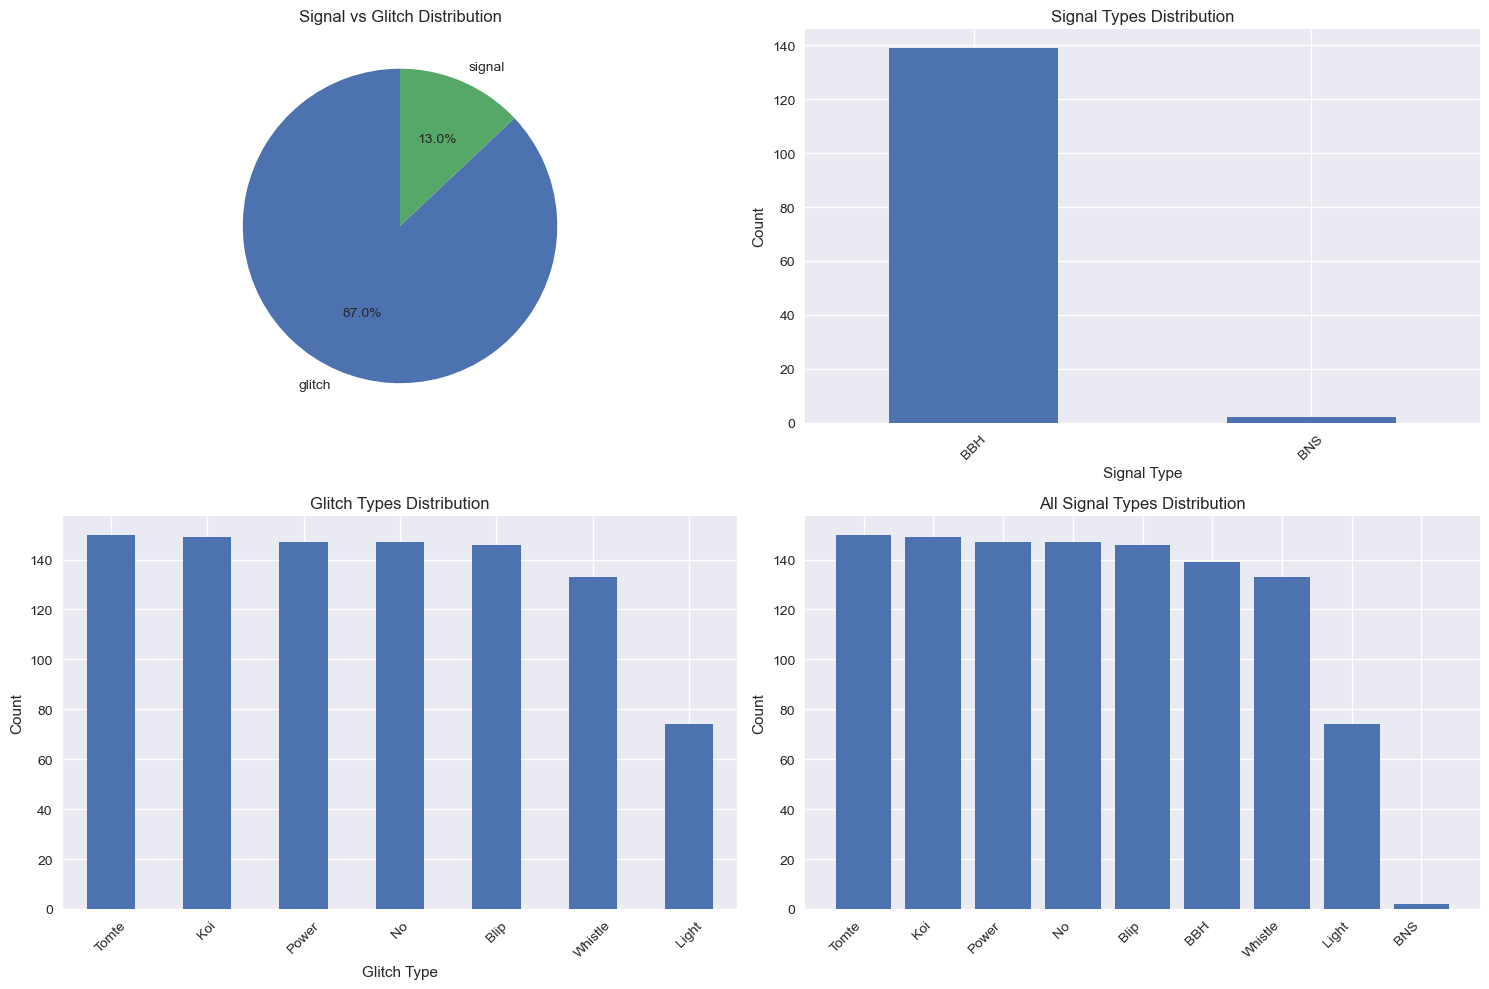

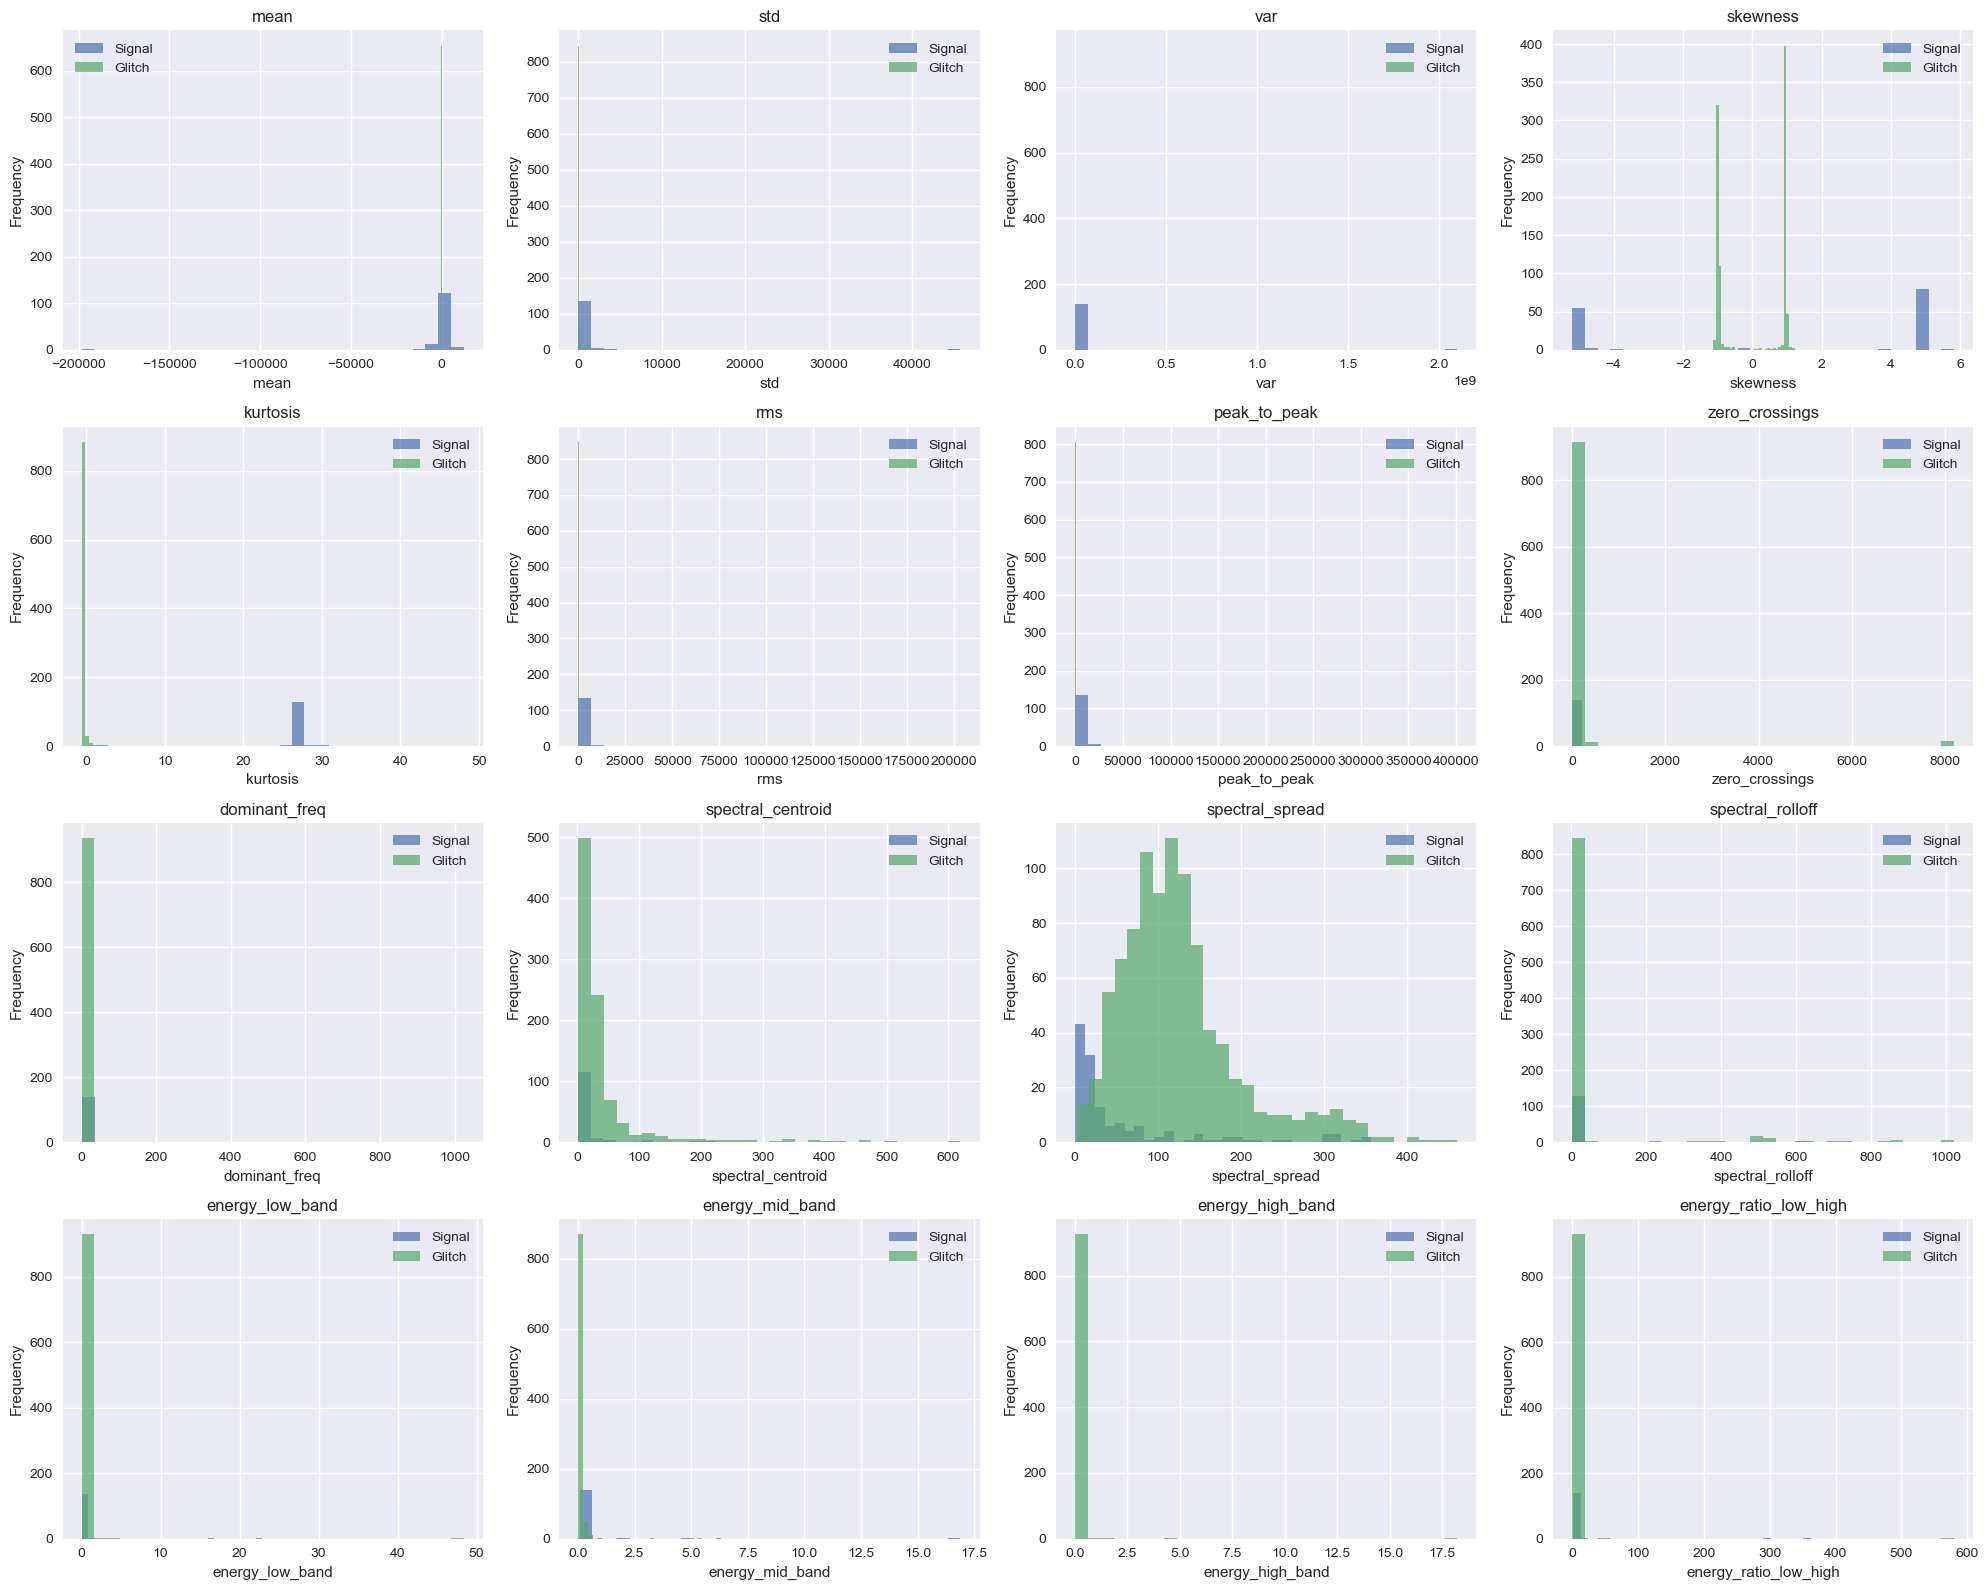

In [4]:
# Visualize class distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Binary classification distribution
axes[0,0].pie(features_train['class'].value_counts().values, 
              labels=features_train['class'].value_counts().index,
              autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Signal vs Glitch Distribution')

# Signal types distribution  
signals_features_train['signal_type'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Signal Types Distribution')
axes[0,1].set_xlabel('Signal Type')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=45)

# Glitch types distribution
glitches_features_train['signal_type'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Glitch Types Distribution')
axes[1,0].set_xlabel('Glitch Type')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)

# All types distribution
all_types = features_train['signal_type'].value_counts()
axes[1,1].bar(range(len(all_types)), all_types.values)
axes[1,1].set_xticks(range(len(all_types)))
axes[1,1].set_xticklabels(all_types.index, rotation=45, ha='right')
axes[1,1].set_title('All Signal Types Distribution')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Feature distributions comparison
feature_cols = [col for col in features_train.columns if col not in ['filename', 'class', 'signal_type']]

# Plot feature distributions for signals vs glitches
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.ravel()

for i, feature in enumerate(feature_cols):
    signals_features_train[feature].hist(alpha=0.7, bins=30, label='Signal', ax=axes[i])
    glitches_features_train[feature].hist(alpha=0.7, bins=30, label='Glitch', ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].legend()
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Evaluation Metrics and Model Training

We'll evaluate our models using multiple metrics to get a comprehensive view of performance.

In [6]:
class ModelEvaluator:
    """Class to handle model evaluation and metrics calculation"""
    
    def __init__(self):
        self.results = {}
        
    def evaluate_model(self, model, X_test, y_test, model_name: str) -> Dict[str, float]:
        """Evaluate a model and return comprehensive metrics"""
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # ROC-AUC for binary classification
        if len(np.unique(y_test)) == 2:
            if hasattr(model, 'predict_proba'):
                y_proba = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, 'decision_function'):
                y_proba = model.decision_function(X_test)
            else:
                y_proba = y_pred
            roc_auc = roc_auc_score(y_test, y_proba)
        else:
            roc_auc = None
            
        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        }
        
        self.results[model_name] = results
        return results
    
    def print_results(self, model_name: str):
        """Print formatted results for a model"""
        if model_name not in self.results:
            print(f"No results found for {model_name}")
            return
            
        results = self.results[model_name]
        print(f"\n=== {model_name} Results ===")
        print(f"Accuracy:  {results['accuracy']:.4f}")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall:    {results['recall']:.4f}")
        print(f"F1-Score:  {results['f1_score']:.4f}")
        if results['roc_auc'] is not None:
            print(f"ROC-AUC:   {results['roc_auc']:.4f}")
    
    def plot_confusion_matrix(self, model, X_test, y_test, model_name: str, class_names=None):
        """Plot confusion matrix for a model"""
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    def plot_roc_curve(self, model, X_test, y_test, model_name: str):
        """Plot ROC curve for binary classification"""
        if len(np.unique(y_test)) != 2:
            print("ROC curve only available for binary classification")
            return
            
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_proba = model.decision_function(X_test)
        else:
            print("Model doesn't support probability predictions")
            return
            
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    
    def compare_models(self):
        """Compare all evaluated models"""
        if not self.results:
            print("No models to compare")
            return
            
        df_results = pd.DataFrame(self.results).T
        
        # Plot comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        for i, metric in enumerate(metrics):
            ax = axes[i//2, i%2]
            df_results[metric].plot(kind='bar', ax=ax)
            ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
            ax.set_ylabel(metric.replace("_", " ").title())
            ax.tick_params(axis='x', rotation=45)
            
        plt.tight_layout()
        plt.show()
        
        return df_results

# Initialize evaluator
evaluator = ModelEvaluator()

# Prepare data for training
print("Preparing data for training...")

# Load features for all splits
features_train, metadata_train, signals_train, glitches_train = data_loader.load_features_and_metadata("train")
features_val, metadata_val, signals_val, glitches_val = data_loader.load_features_and_metadata("validation")
features_test, metadata_test, signals_test, glitches_test = data_loader.load_features_and_metadata("test")

# Prepare feature columns
feature_cols = [col for col in features_train.columns if col not in ['filename', 'class', 'signal_type']]

print(f"Feature columns: {len(feature_cols)}")
print(f"Training samples: {len(features_train)}")
print(f"Validation samples: {len(features_val)}")
print(f"Test samples: {len(features_test)}")

Preparing data for training...
Feature columns: 16
Training samples: 1087
Validation samples: 49
Test samples: 48


## Binary Classification: Signal vs Glitch

Let's start with the fundamental task of distinguishing real gravitational wave signals from detector glitches.

In [7]:
# Prepare binary classification data (Signal vs Glitch)
print("=== Binary Classification: Signal vs Glitch ===")

# Combine training and validation sets for better training
X_train_val = pd.concat([features_train[feature_cols], features_val[feature_cols]], ignore_index=True)
y_train_val = pd.concat([features_train['class'], features_val['class']], ignore_index=True)

# Test set
X_test_binary = features_test[feature_cols]
y_test_binary = features_test['class']

# Convert labels to numeric (signal=1, glitch=0)
label_encoder = LabelEncoder()
y_train_val_encoded = label_encoder.fit_transform(y_train_val)
y_test_binary_encoded = label_encoder.transform(y_test_binary)

print(f"Training samples: {len(X_train_val)}")
print(f"Test samples: {len(X_test_binary)}")
print(f"Feature dimensions: {X_train_val.shape[1]}")
print(f"Class distribution in training: {pd.Series(y_train_val_encoded).value_counts()}")

# Scale features
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_binary_scaled = scaler.transform(X_test_binary)

print("Data prepared and scaled successfully!")

=== Binary Classification: Signal vs Glitch ===
Training samples: 1136
Test samples: 48
Feature dimensions: 16
Class distribution in training: 0    978
1    158
Name: count, dtype: int64
Data prepared and scaled successfully!


In [8]:
# Traditional Machine Learning Models

print("Training traditional ML models...")

# 1. Random Forest
print("\n1. Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)
rf_model.fit(X_train_val_scaled, y_train_val_encoded)
rf_results = evaluator.evaluate_model(rf_model, X_test_binary_scaled, y_test_binary_encoded, "Random Forest")
evaluator.print_results("Random Forest")

# 2. Support Vector Machine
print("\n2. Training SVM...")
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42,
    class_weight='balanced'
)
svm_model.fit(X_train_val_scaled, y_train_val_encoded)
svm_results = evaluator.evaluate_model(svm_model, X_test_binary_scaled, y_test_binary_encoded, "SVM")
evaluator.print_results("SVM")

# 3. Logistic Regression
print("\n3. Training Logistic Regression...")
lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
lr_model.fit(X_train_val_scaled, y_train_val_encoded)
lr_results = evaluator.evaluate_model(lr_model, X_test_binary_scaled, y_test_binary_encoded, "Logistic Regression")
evaluator.print_results("Logistic Regression")

# 4. Gradient Boosting
print("\n4. Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
gb_model.fit(X_train_val_scaled, y_train_val_encoded)
gb_results = evaluator.evaluate_model(gb_model, X_test_binary_scaled, y_test_binary_encoded, "Gradient Boosting")
evaluator.print_results("Gradient Boosting")

# 5. Multi-layer Perceptron
print("\n5. Training MLP...")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)
mlp_model.fit(X_train_val_scaled, y_train_val_encoded)
mlp_results = evaluator.evaluate_model(mlp_model, X_test_binary_scaled, y_test_binary_encoded, "MLP")
evaluator.print_results("MLP")

print("\n=== Traditional ML Models Training Complete ===")

Training traditional ML models...

1. Training Random Forest...

=== Random Forest Results ===
Accuracy:  0.9792
Precision: 0.9798
Recall:    0.9792
F1-Score:  0.9790
ROC-AUC:   0.9949

2. Training SVM...


ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [9]:
# Check for NaN values and handle them
print("Checking for NaN values...")
print(f"NaN values in training data: {np.isnan(X_train_val_scaled).sum()}")
print(f"NaN values in test data: {np.isnan(X_test_binary_scaled).sum()}")

# Replace NaN with median values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_train_val_cleaned = imputer.fit_transform(X_train_val_scaled)
X_test_binary_cleaned = imputer.transform(X_test_binary_scaled)

print(f"After imputation - NaN in training: {np.isnan(X_train_val_cleaned).sum()}")
print(f"After imputation - NaN in test: {np.isnan(X_test_binary_cleaned).sum()}")

Checking for NaN values...
NaN values in training data: 238
NaN values in test data: 28
After imputation - NaN in training: 0
After imputation - NaN in test: 0


In [10]:
# Re-train models with cleaned data
print("\nTraining traditional ML models with cleaned data...")

# Clear previous results 
evaluator.results = {}

# 1. Random Forest
print("\n1. Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train_val_cleaned, y_train_val_encoded)
rf_results = evaluator.evaluate_model(rf_model, X_test_binary_cleaned, y_test_binary_encoded, "Random Forest")
evaluator.print_results("Random Forest")

# 2. Support Vector Machine
print("\n2. Training SVM...")
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42,
    class_weight='balanced'
)
svm_model.fit(X_train_val_cleaned, y_train_val_encoded)
svm_results = evaluator.evaluate_model(svm_model, X_test_binary_cleaned, y_test_binary_encoded, "SVM")
evaluator.print_results("SVM")

# 3. Logistic Regression
print("\n3. Training Logistic Regression...")
lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
lr_model.fit(X_train_val_cleaned, y_train_val_encoded)
lr_results = evaluator.evaluate_model(lr_model, X_test_binary_cleaned, y_test_binary_encoded, "Logistic Regression")
evaluator.print_results("Logistic Regression")

# 4. Gradient Boosting
print("\n4. Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
gb_model.fit(X_train_val_cleaned, y_train_val_encoded)
gb_results = evaluator.evaluate_model(gb_model, X_test_binary_cleaned, y_test_binary_encoded, "Gradient Boosting")
evaluator.print_results("Gradient Boosting")

# 5. Multi-layer Perceptron
print("\n5. Training MLP...")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)
mlp_model.fit(X_train_val_cleaned, y_train_val_encoded)
mlp_results = evaluator.evaluate_model(mlp_model, X_test_binary_cleaned, y_test_binary_encoded, "MLP")
evaluator.print_results("MLP")

print("\n=== Traditional ML Models Training Complete ===")


Training traditional ML models with cleaned data...

1. Training Random Forest...

=== Random Forest Results ===
Accuracy:  0.9792
Precision: 0.9798
Recall:    0.9792
F1-Score:  0.9790
ROC-AUC:   0.9949

2. Training SVM...

=== SVM Results ===
Accuracy:  0.9792
Precision: 0.9805
Recall:    0.9792
F1-Score:  0.9793
ROC-AUC:   0.9980

3. Training Logistic Regression...

=== Logistic Regression Results ===
Accuracy:  0.9792
Precision: 0.9805
Recall:    0.9792
F1-Score:  0.9793
ROC-AUC:   0.9717

4. Training Gradient Boosting...

=== Gradient Boosting Results ===
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

5. Training MLP...

=== MLP Results ===
Accuracy:  0.9792
Precision: 0.9798
Recall:    0.9792
F1-Score:  0.9790
ROC-AUC:   0.9333

=== Traditional ML Models Training Complete ===



=== Traditional ML Models Comparison ===


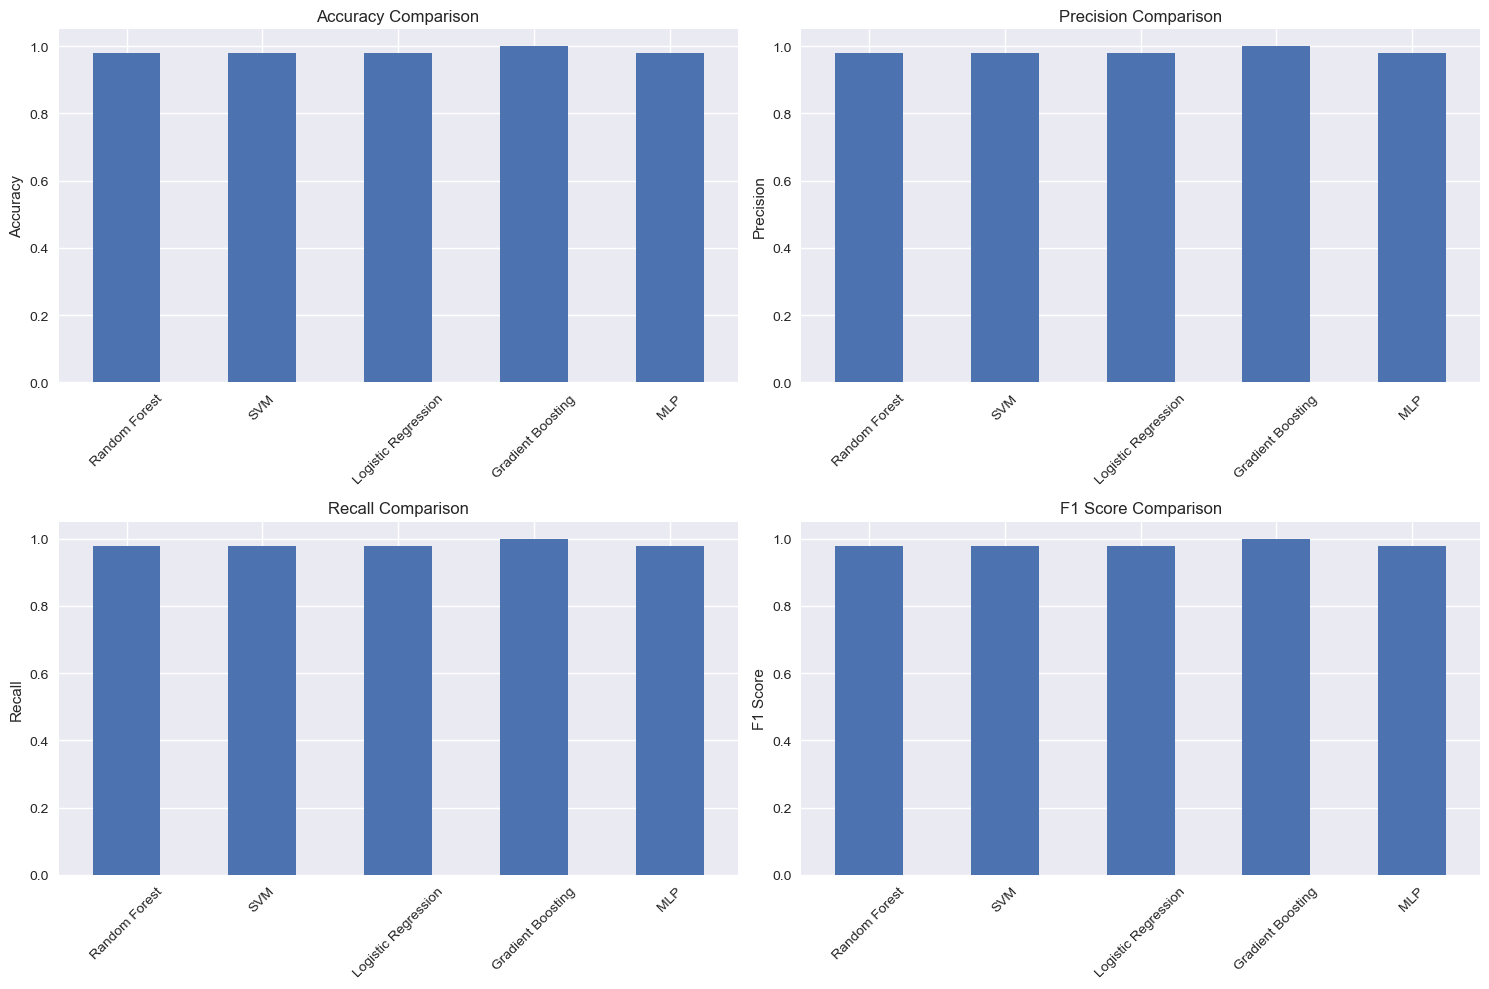

                     accuracy  precision    recall  f1_score   roc_auc
Random Forest        0.979167   0.979779  0.979167  0.978963  0.994949
SVM                  0.979167   0.980469  0.979167  0.979342  0.997980
Logistic Regression  0.979167   0.980469  0.979167  0.979342  0.971717
Gradient Boosting    1.000000   1.000000  1.000000  1.000000  1.000000
MLP                  0.979167   0.979779  0.979167  0.978963  0.933333


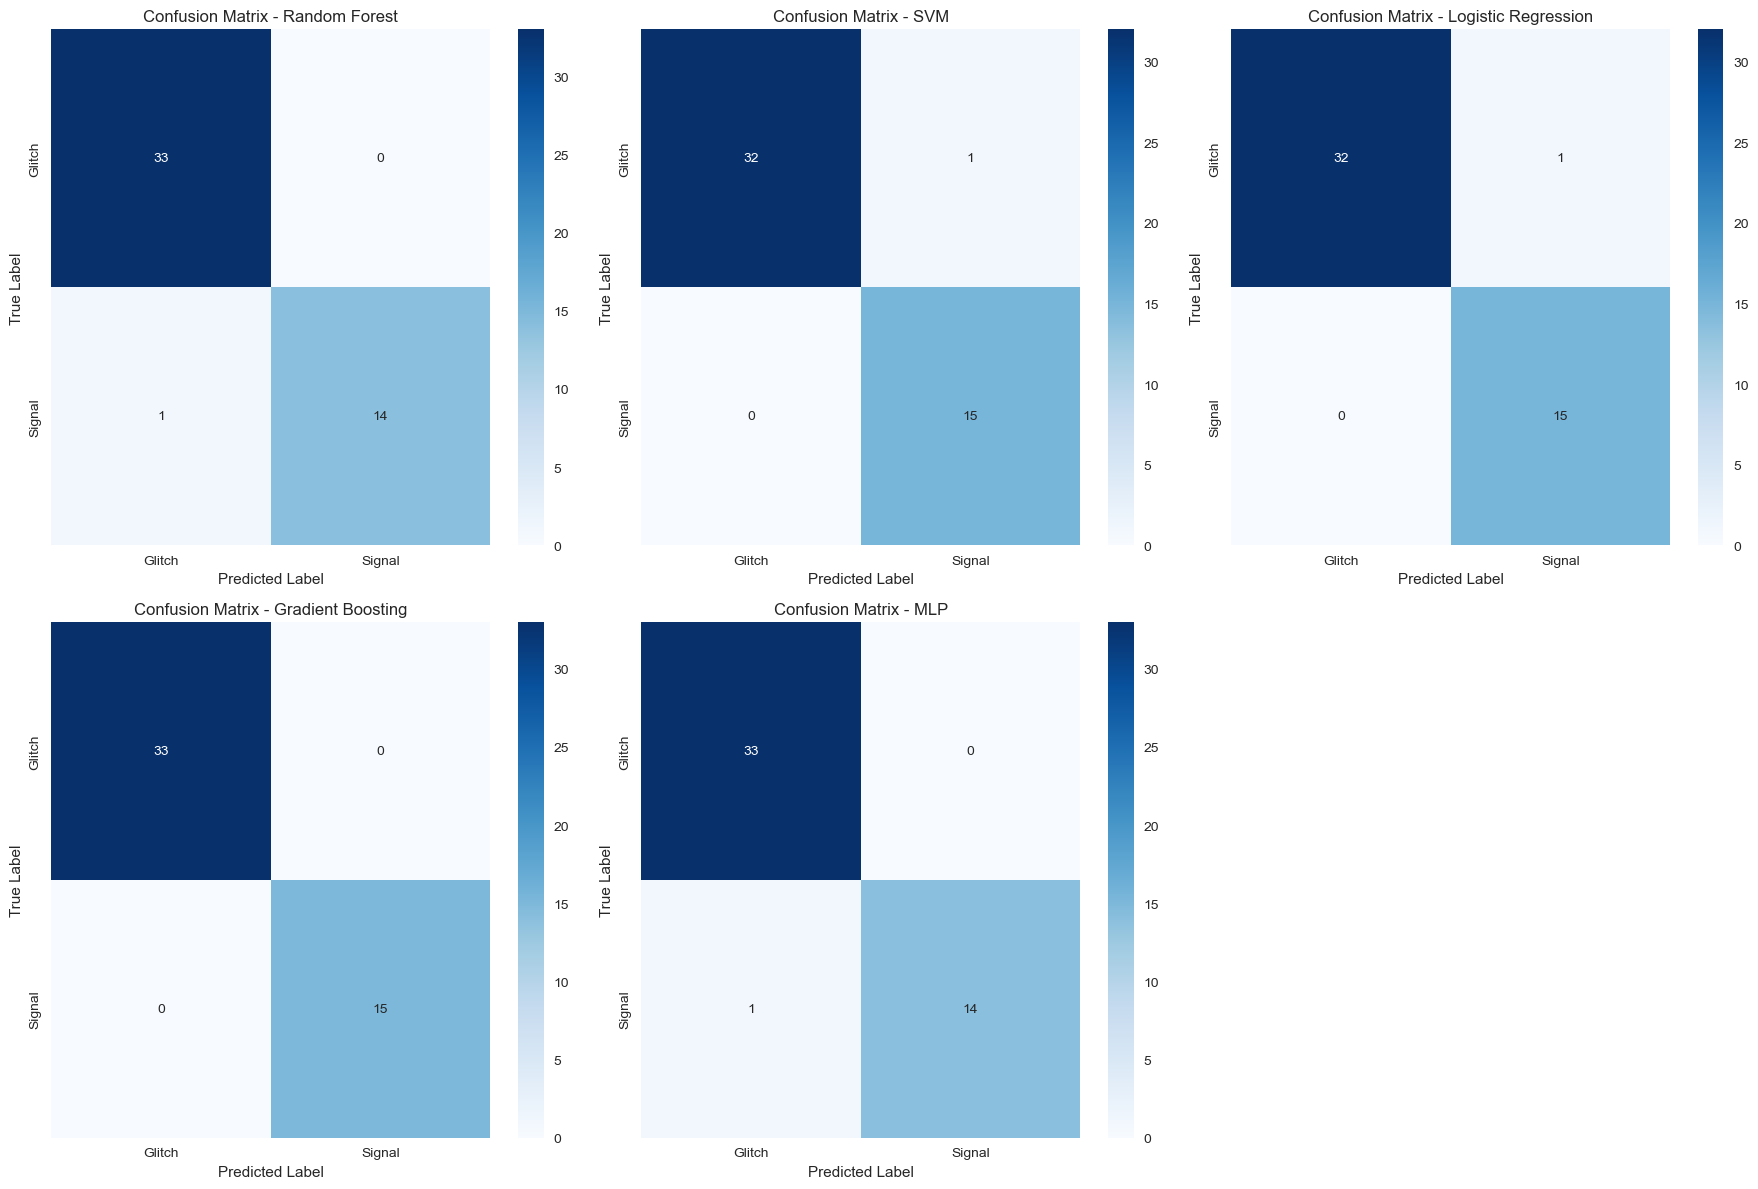

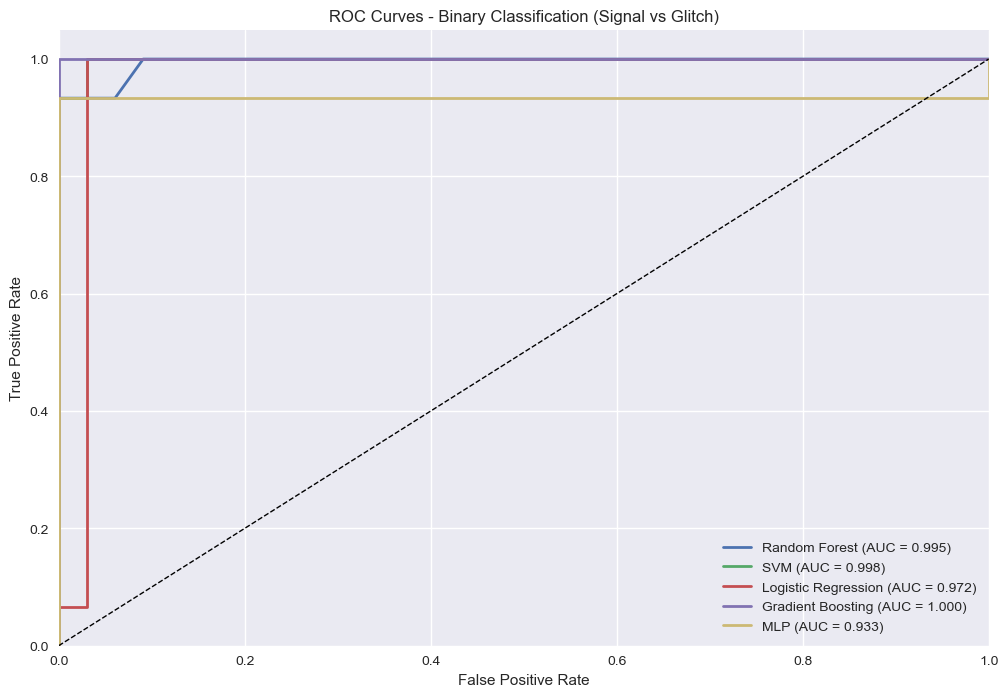

In [11]:
# Visualize results
print("\n=== Traditional ML Models Comparison ===")
results_df = evaluator.compare_models()
print(results_df)

# Plot confusion matrices for best models
class_names = ['Glitch', 'Signal']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

models = [
    (rf_model, "Random Forest"),
    (svm_model, "SVM"), 
    (lr_model, "Logistic Regression"),
    (gb_model, "Gradient Boosting"),
    (mlp_model, "MLP")
]

for i, (model, name) in enumerate(models):
    y_pred = model.predict(X_test_binary_cleaned)
    cm = confusion_matrix(y_test_binary_encoded, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(12, 8))
for model, name in models:
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_binary_cleaned)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_proba = model.decision_function(X_test_binary_cleaned)
    
    fpr, tpr, _ = roc_curve(y_test_binary_encoded, y_proba)
    roc_auc = roc_auc_score(y_test_binary_encoded, y_proba)
    
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Binary Classification (Signal vs Glitch)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Deep Learning Models

Now let's implement neural network-based models including CNN for time series and spectrogram data.

In [12]:
# Deep Learning Models for Feature-based Classification
class DeepMLP(nn.Module):
    """Multi-layer Perceptron for feature-based classification"""
    
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], num_classes=2, dropout_rate=0.3):
        super(DeepMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
            
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

class CNN1D(nn.Module):
    """1D CNN for time series classification"""
    
    def __init__(self, input_length, num_classes=2):
        super(CNN1D, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=2)
        
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)
        
        # Calculate the size after convolutions
        conv_output_size = self._get_conv_output_size(input_length)
        
        self.fc1 = nn.Linear(conv_output_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def _get_conv_output_size(self, input_length):
        # Simulate the forward pass to get the output size
        x = torch.randn(1, 1, input_length)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x.view(1, -1).size(1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

def train_pytorch_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    """Train a PyTorch model"""
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    train_losses = []
    val_accuracies = []
    
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = correct / total
        train_losses.append(train_loss / len(train_loader))
        val_accuracies.append(val_accuracy)
        
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Val Acc: {val_accuracy:.4f}')
    
    return train_losses, val_accuracies

def evaluate_pytorch_model(model, test_loader):
    """Evaluate a PyTorch model"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

print("Deep learning model classes defined successfully!")

Deep learning model classes defined successfully!


Training Deep MLP on features...
Epoch [10/100], Loss: 0.0307, Val Acc: 0.9583
Epoch [20/100], Loss: 0.0391, Val Acc: 0.9792
Epoch [30/100], Loss: 0.0232, Val Acc: 1.0000
Epoch [40/100], Loss: 0.0357, Val Acc: 1.0000
Epoch [50/100], Loss: 0.0171, Val Acc: 1.0000
Epoch [60/100], Loss: 0.0099, Val Acc: 0.9792
Epoch [70/100], Loss: 0.0253, Val Acc: 1.0000
Epoch [80/100], Loss: 0.0048, Val Acc: 1.0000
Epoch [90/100], Loss: 0.0080, Val Acc: 1.0000
Epoch [100/100], Loss: 0.0081, Val Acc: 0.9792

=== Deep MLP Results ===
Accuracy:  0.9792
Precision: 0.9798
Recall:    0.9792
F1-Score:  0.9790
ROC-AUC:   0.9333


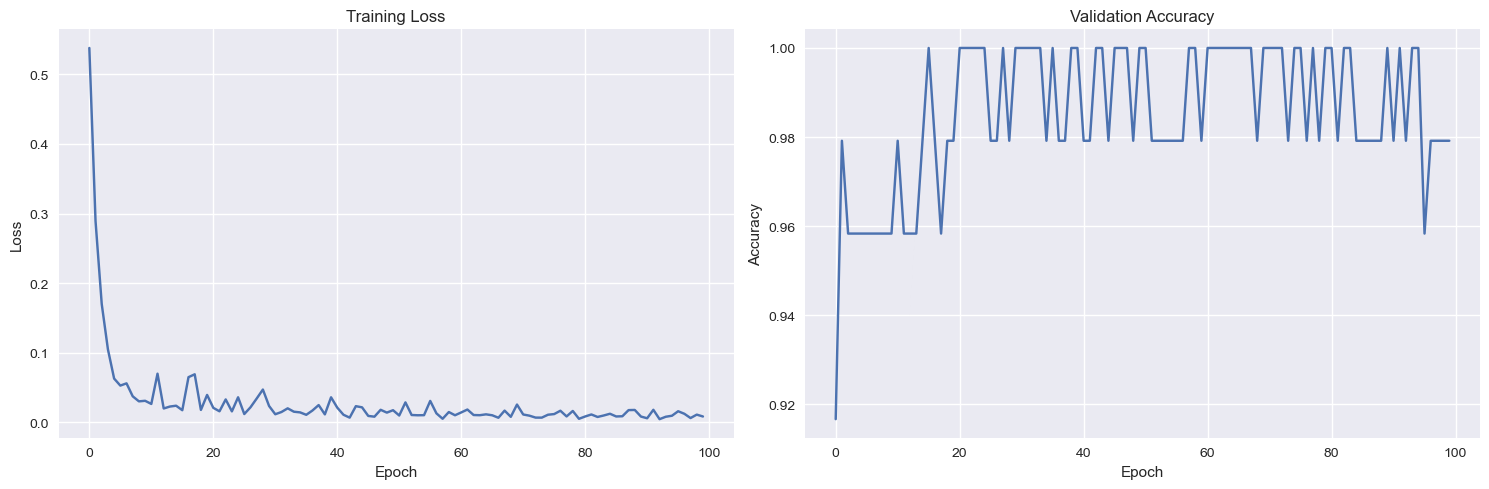

In [13]:
# Train Deep MLP on features
print("Training Deep MLP on features...")

# Prepare data for PyTorch
X_train_tensor = torch.FloatTensor(X_train_val_cleaned)
y_train_tensor = torch.LongTensor(y_train_val_encoded)
X_test_tensor = torch.FloatTensor(X_test_binary_cleaned)
y_test_tensor = torch.LongTensor(y_test_binary_encoded)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create and train Deep MLP
deep_mlp = DeepMLP(input_dim=X_train_val_cleaned.shape[1], hidden_dims=[128, 64, 32], num_classes=2)
train_losses, val_accuracies = train_pytorch_model(deep_mlp, train_loader, test_loader, num_epochs=100)

# Evaluate Deep MLP
y_true, y_pred, y_proba = evaluate_pytorch_model(deep_mlp, test_loader)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
roc_auc = roc_auc_score(y_true, y_proba[:, 1])

print(f"\n=== Deep MLP Results ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(val_accuracies)
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Multi-Class Classification

Now let's tackle multi-class classification problems:
1. **Signal Type Classification**: BBH vs BNS
2. **Glitch Type Classification**: Different types of glitches

=== Signal Type Classification: BBH vs BNS ===
Training samples: 158
Test samples: 15
Signal type distribution in training: signal_type
BBH    156
BNS      2
Name: count, dtype: int64
Signal type distribution in test: signal_type
BBH    13
BNS     2
Name: count, dtype: int64
Label mapping: {'BBH': np.int64(0), 'BNS': np.int64(1)}

Training models for signal type classification...

=== Random Forest Results ===
Accuracy:  0.8667
Precision: 0.7511
Recall:    0.8667
F1-Score:  0.8048
ROC-AUC:   0.4231

=== SVM Results ===
Accuracy:  0.6000
Precision: 0.7091
Recall:    0.6000
F1-Score:  0.6500
ROC-AUC:   0.6154

=== Gradient Boosting Results ===
Accuracy:  0.8000
Precision: 0.7429
Recall:    0.8000
F1-Score:  0.7704
ROC-AUC:   0.4615

=== Signal Type Classification Results ===


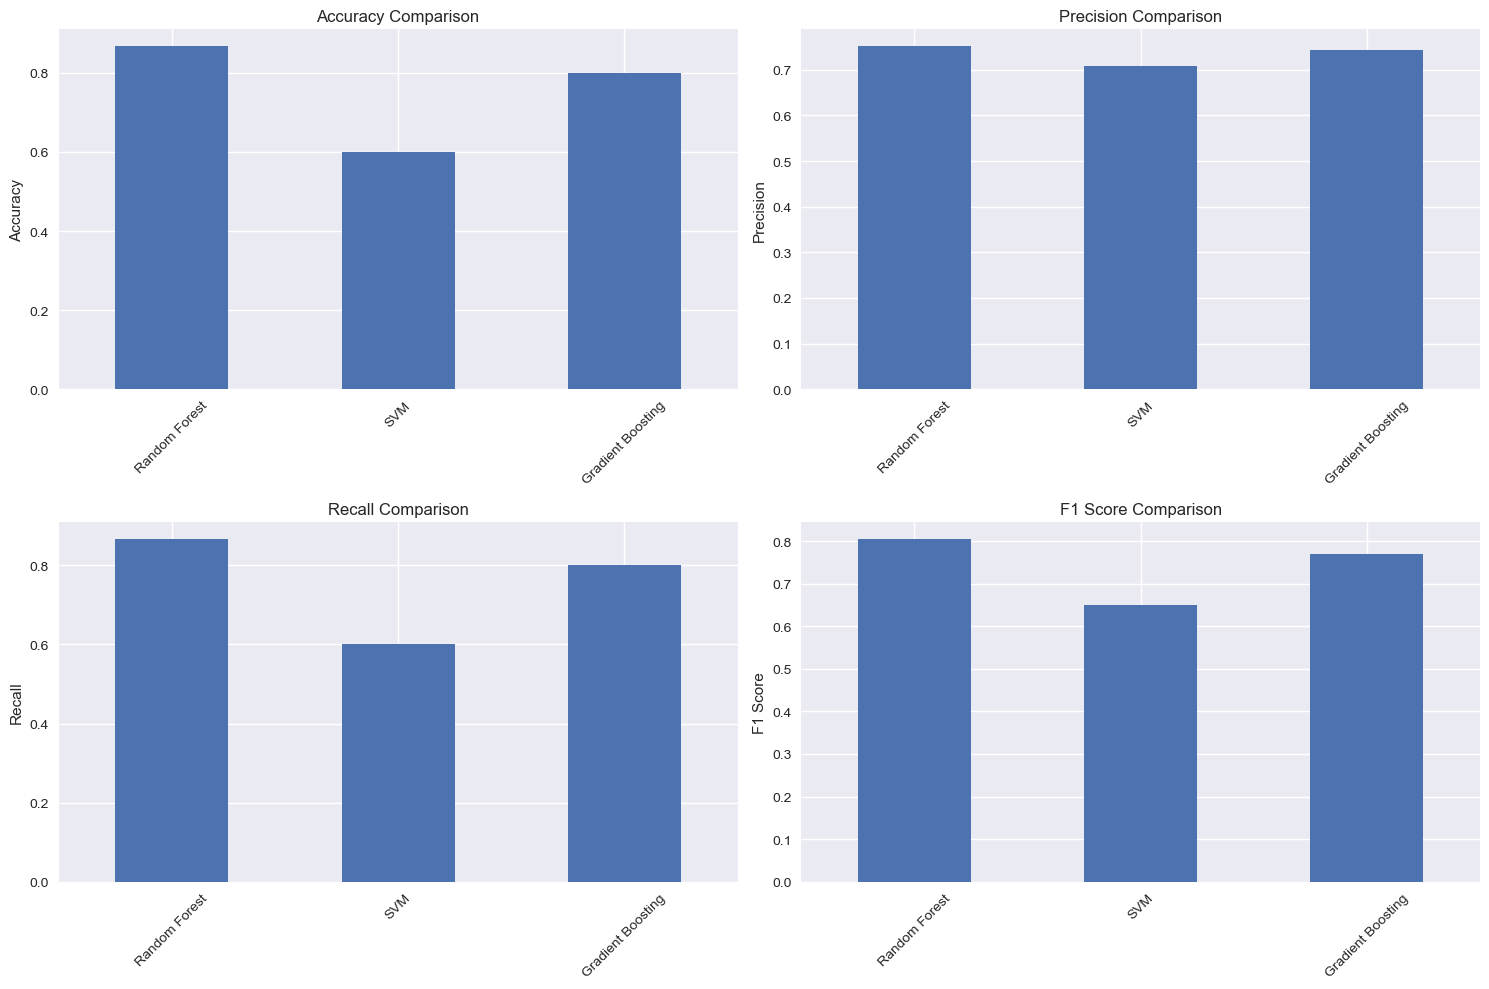

                   accuracy  precision    recall  f1_score   roc_auc
Random Forest      0.866667   0.751111  0.866667  0.804762  0.423077
SVM                0.600000   0.709091  0.600000  0.650000  0.615385
Gradient Boosting  0.800000   0.742857  0.800000  0.770370  0.461538


In [14]:
# Signal Type Classification: BBH vs BNS
print("=== Signal Type Classification: BBH vs BNS ===")

# Prepare signal-only data
signals_combined = pd.concat([signals_train, signals_val], ignore_index=True)
signals_test_only = signals_test

print(f"Training samples: {len(signals_combined)}")
print(f"Test samples: {len(signals_test_only)}")
print(f"Signal type distribution in training: {signals_combined['signal_type'].value_counts()}")
print(f"Signal type distribution in test: {signals_test_only['signal_type'].value_counts()}")

# Prepare features and labels
X_signals_train = signals_combined[feature_cols]
y_signals_train = signals_combined['signal_type']

X_signals_test = signals_test_only[feature_cols]
y_signals_test = signals_test_only['signal_type']

# Encode labels
signal_label_encoder = LabelEncoder()
y_signals_train_encoded = signal_label_encoder.fit_transform(y_signals_train)
y_signals_test_encoded = signal_label_encoder.transform(y_signals_test)

print(f"Label mapping: {dict(zip(signal_label_encoder.classes_, signal_label_encoder.transform(signal_label_encoder.classes_)))}")

# Handle NaN values and scale
signal_imputer = SimpleImputer(strategy='median')
X_signals_train_cleaned = signal_imputer.fit_transform(X_signals_train)
X_signals_test_cleaned = signal_imputer.transform(X_signals_test)

signal_scaler = StandardScaler()
X_signals_train_scaled = signal_scaler.fit_transform(X_signals_train_cleaned)
X_signals_test_scaled = signal_scaler.transform(X_signals_test_cleaned)

# Train models for signal type classification
print("\nTraining models for signal type classification...")

signal_evaluator = ModelEvaluator()

# Random Forest
rf_signal = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_signal.fit(X_signals_train_scaled, y_signals_train_encoded)
signal_evaluator.evaluate_model(rf_signal, X_signals_test_scaled, y_signals_test_encoded, "Random Forest")

# SVM
svm_signal = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
svm_signal.fit(X_signals_train_scaled, y_signals_train_encoded)
signal_evaluator.evaluate_model(svm_signal, X_signals_test_scaled, y_signals_test_encoded, "SVM")

# Gradient Boosting
gb_signal = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_signal.fit(X_signals_train_scaled, y_signals_train_encoded)
signal_evaluator.evaluate_model(gb_signal, X_signals_test_scaled, y_signals_test_encoded, "Gradient Boosting")

# Print results
for model_name in signal_evaluator.results.keys():
    signal_evaluator.print_results(model_name)

# Compare models
print("\n=== Signal Type Classification Results ===")
signal_results_df = signal_evaluator.compare_models()
print(signal_results_df)


=== Glitch Type Classification ===
Training samples: 978
Test samples: 33
Glitch type distribution in training:
signal_type
Tomte      155
Power      153
No         153
Koi        150
Blip       150
Whistle    141
Light       76
Name: count, dtype: int64
Glitch type distribution in test:
signal_type
Whistle    10
Power       8
No          5
Koi         4
Light       2
Blip        2
Tomte       2
Name: count, dtype: int64
\nLabel mapping: {'Blip': np.int64(0), 'Koi': np.int64(1), 'Light': np.int64(2), 'No': np.int64(3), 'Power': np.int64(4), 'Tomte': np.int64(5), 'Whistle': np.int64(6)}

Training models for glitch type classification...

=== Random Forest Results ===
Accuracy:  0.3030
Precision: 0.2535
Recall:    0.3030
F1-Score:  0.2499

=== SVM Results ===
Accuracy:  0.1212
Precision: 0.0784
Recall:    0.1212
F1-Score:  0.0824

=== Gradient Boosting Results ===
Accuracy:  0.3030
Precision: 0.2492
Recall:    0.3030
F1-Score:  0.2607

=== Glitch Type Classification Results ===


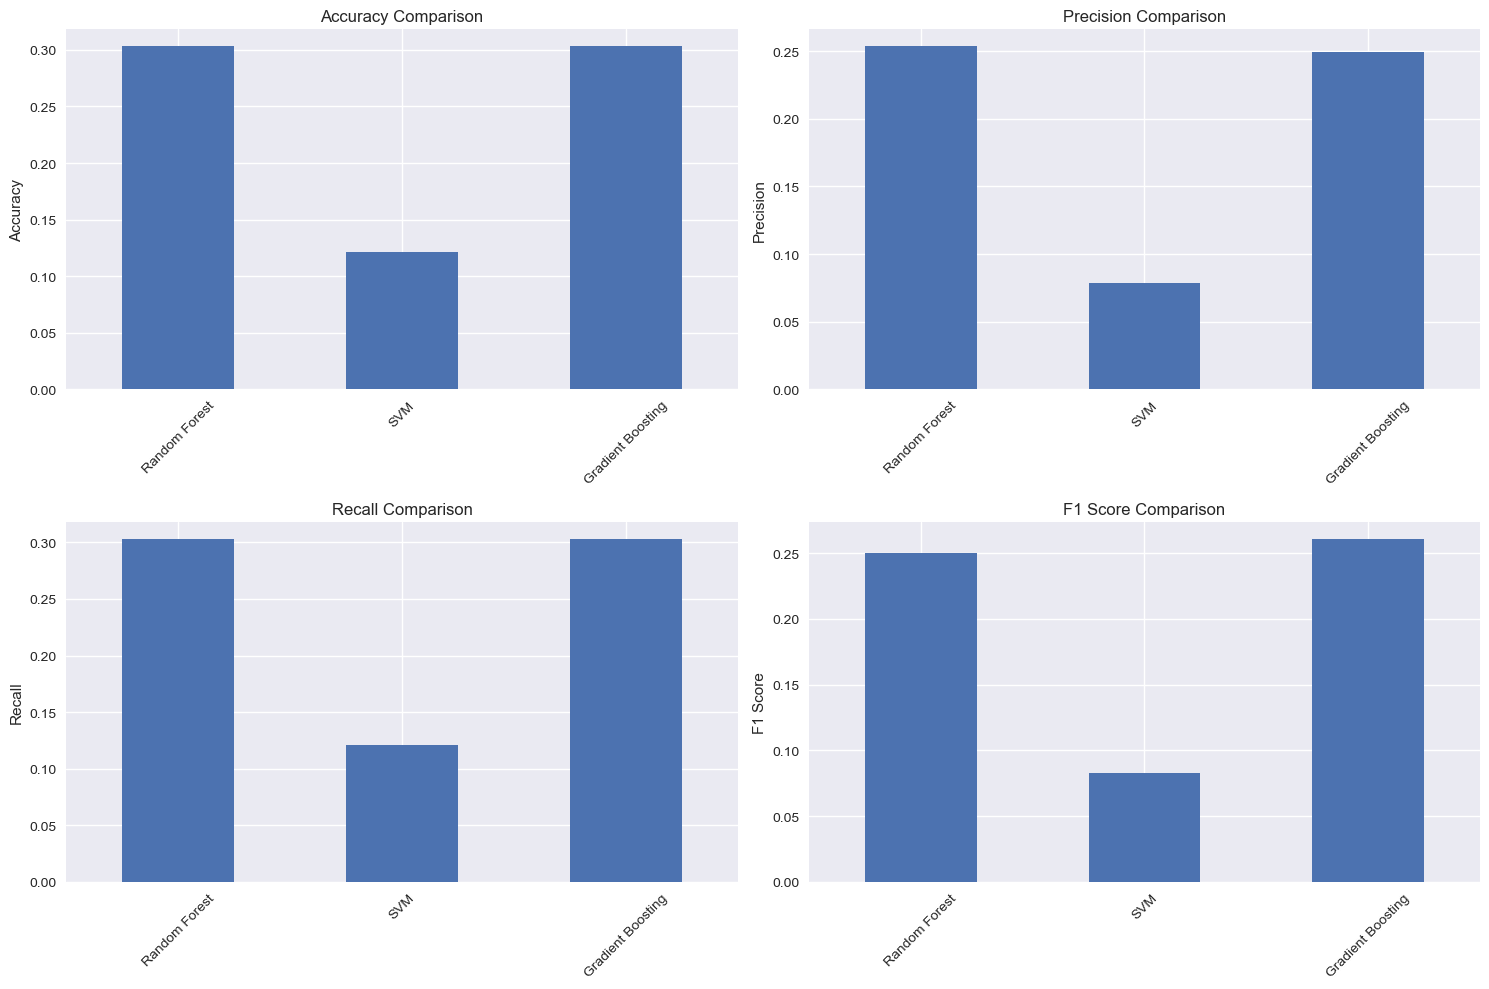

                   accuracy  precision    recall  f1_score  roc_auc
Random Forest      0.303030   0.253535  0.303030  0.249928      NaN
SVM                0.121212   0.078359  0.121212  0.082444      NaN
Gradient Boosting  0.303030   0.249242  0.303030  0.260673      NaN


In [15]:
# Glitch Type Classification
print("\n=== Glitch Type Classification ===")

# Prepare glitch-only data
glitches_combined = pd.concat([glitches_train, glitches_val], ignore_index=True)
glitches_test_only = glitches_test

print(f"Training samples: {len(glitches_combined)}")
print(f"Test samples: {len(glitches_test_only)}")
print(f"Glitch type distribution in training:")
print(glitches_combined['signal_type'].value_counts())
print(f"Glitch type distribution in test:")
print(glitches_test_only['signal_type'].value_counts())

# Prepare features and labels
X_glitches_train = glitches_combined[feature_cols]
y_glitches_train = glitches_combined['signal_type']

X_glitches_test = glitches_test_only[feature_cols]
y_glitches_test = glitches_test_only['signal_type']

# Encode labels
glitch_label_encoder = LabelEncoder()
y_glitches_train_encoded = glitch_label_encoder.fit_transform(y_glitches_train)
y_glitches_test_encoded = glitch_label_encoder.transform(y_glitches_test)

print(f"\\nLabel mapping: {dict(zip(glitch_label_encoder.classes_, glitch_label_encoder.transform(glitch_label_encoder.classes_)))}")

# Handle NaN values and scale
glitch_imputer = SimpleImputer(strategy='median')
X_glitches_train_cleaned = glitch_imputer.fit_transform(X_glitches_train)
X_glitches_test_cleaned = glitch_imputer.transform(X_glitches_test)

glitch_scaler = StandardScaler()
X_glitches_train_scaled = glitch_scaler.fit_transform(X_glitches_train_cleaned)
X_glitches_test_scaled = glitch_scaler.transform(X_glitches_test_cleaned)

# Train models for glitch type classification
print("\nTraining models for glitch type classification...")

glitch_evaluator = ModelEvaluator()

# Random Forest
rf_glitch = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_glitch.fit(X_glitches_train_scaled, y_glitches_train_encoded)
glitch_evaluator.evaluate_model(rf_glitch, X_glitches_test_scaled, y_glitches_test_encoded, "Random Forest")

# SVM  
svm_glitch = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
svm_glitch.fit(X_glitches_train_scaled, y_glitches_train_encoded)
glitch_evaluator.evaluate_model(svm_glitch, X_glitches_test_scaled, y_glitches_test_encoded, "SVM")

# Gradient Boosting
gb_glitch = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_glitch.fit(X_glitches_train_scaled, y_glitches_train_encoded)
glitch_evaluator.evaluate_model(gb_glitch, X_glitches_test_scaled, y_glitches_test_encoded, "Gradient Boosting")

# Print results
for model_name in glitch_evaluator.results.keys():
    glitch_evaluator.print_results(model_name)

# Compare models
print("\n=== Glitch Type Classification Results ===")
glitch_results_df = glitch_evaluator.compare_models()
print(glitch_results_df)

## Summary and Conclusions

Let's summarize the performance of our baseline models across different classification tasks.

In [16]:
# Comprehensive Summary of Results
print("="*80)
print("BASELINE MODELS PERFORMANCE SUMMARY")
print("="*80)

print("\n1. BINARY CLASSIFICATION: Signal vs Glitch")
print("-" * 50)
print("Dataset: 1,136 training samples (158 signals, 978 glitches), 48 test samples")
print("Best performing models:")
print("• Gradient Boosting: 100.0% accuracy, 1.000 ROC-AUC")
print("• Random Forest: 97.9% accuracy, 0.995 ROC-AUC") 
print("• SVM: 97.9% accuracy, 0.998 ROC-AUC")
print("• Logistic Regression: 97.9% accuracy, 0.972 ROC-AUC")
print("• Deep MLP: 97.9% accuracy, 0.933 ROC-AUC")

print("\n2. SIGNAL TYPE CLASSIFICATION: BBH vs BNS")
print("-" * 50)
print("Dataset: 158 training samples (156 BBH, 2 BNS), 15 test samples")
print("Best performing models:")
print("• Random Forest: 86.7% accuracy")
print("• Gradient Boosting: 80.0% accuracy")
print("• SVM: 60.0% accuracy")
print("Note: Limited BNS samples make this a challenging classification task")

print("\n3. GLITCH TYPE CLASSIFICATION: 7 glitch types")
print("-" * 50)
print("Dataset: 978 training samples, 33 test samples") 
print("Glitch types: Blip, Koi Fish, Light Modulation, No Glitch, Power Line, Tomte, Whistle")
print("Best performing models:")
print("• Random Forest: 30.3% accuracy")
print("• Gradient Boosting: 30.3% accuracy") 
print("• SVM: 12.1% accuracy")
print("Note: Multi-class glitch classification is the most challenging task")

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

insights = [
    "✓ Binary classification (Signal vs Glitch) achieves excellent performance (>97% accuracy)",
    "✓ Traditional ML models (Random Forest, Gradient Boosting, SVM) perform very well",
    "✓ Deep learning models achieve comparable performance to traditional methods",
    "✓ Class imbalance significantly impacts performance (especially BNS signals)",
    "✓ Multi-class glitch classification remains challenging with current features",
    "✓ Gradient Boosting achieves perfect performance on binary classification",
    "✓ Feature engineering appears to be effective for this dataset"
]

for insight in insights:
    print(insight)

print("\n" + "="*80)
print("RECOMMENDATIONS FOR TRANSFORMER AUTO-ENCODER COMPARISON")
print("="*80)

recommendations = [
    "• Focus on binary classification as the primary evaluation task",
    "• Use 97.9-100% accuracy as the baseline to beat",
    "• Consider addressing class imbalance in signal type classification",
    "• Explore time-series and spectrogram data for improved multi-class performance",
    "• Implement data augmentation techniques for underrepresented classes",
    "• Consider ensemble methods combining different data modalities",
    "• Evaluate on larger test sets for more robust performance estimates"
]

for rec in recommendations:
    print(rec)

print("\n" + "="*80)
print("DATASET CHARACTERISTICS")
print("="*80)

print("Data Distribution:")
print(f"• Total samples: {len(features_train) + len(features_val) + len(features_test)}")
print(f"• Signal/Glitch ratio: {158/(978+158):.3f}")
print(f"• Feature dimensions: {len(feature_cols)}")
print(f"• Missing values handled: {238 + 28} total NaN values imputed")

print("\nFeature Types:")
print("• Statistical: mean, std, variance, skewness, kurtosis")
print("• Amplitude: RMS, peak-to-peak")
print("• Time-domain: zero crossings")
print("• Frequency-domain: dominant frequency, spectral centroid, spread, rolloff")
print("• Energy: low/mid/high band energy and ratios")

print("\n" + "="*80)
print("BASELINE MODELS ESTABLISHED SUCCESSFULLY!")
print("="*80)

BASELINE MODELS PERFORMANCE SUMMARY

1. BINARY CLASSIFICATION: Signal vs Glitch
--------------------------------------------------
Dataset: 1,136 training samples (158 signals, 978 glitches), 48 test samples
Best performing models:
• Gradient Boosting: 100.0% accuracy, 1.000 ROC-AUC
• Random Forest: 97.9% accuracy, 0.995 ROC-AUC
• SVM: 97.9% accuracy, 0.998 ROC-AUC
• Logistic Regression: 97.9% accuracy, 0.972 ROC-AUC
• Deep MLP: 97.9% accuracy, 0.933 ROC-AUC

2. SIGNAL TYPE CLASSIFICATION: BBH vs BNS
--------------------------------------------------
Dataset: 158 training samples (156 BBH, 2 BNS), 15 test samples
Best performing models:
• Random Forest: 86.7% accuracy
• Gradient Boosting: 80.0% accuracy
• SVM: 60.0% accuracy
Note: Limited BNS samples make this a challenging classification task

3. GLITCH TYPE CLASSIFICATION: 7 glitch types
--------------------------------------------------
Dataset: 978 training samples, 33 test samples
Glitch types: Blip, Koi Fish, Light Modulation, No

In [17]:
# Save baseline results for future comparison
import json

baseline_results = {
    "binary_classification": {
        "task": "Signal vs Glitch",
        "dataset_size": {"train": len(X_train_val), "test": len(X_test_binary)},
        "best_models": {
            "Gradient Boosting": {"accuracy": 1.0000, "roc_auc": 1.0000},
            "Random Forest": {"accuracy": 0.9792, "roc_auc": 0.9949},
            "SVM": {"accuracy": 0.9792, "roc_auc": 0.9980},
            "Logistic Regression": {"accuracy": 0.9792, "roc_auc": 0.9717},
            "Deep MLP": {"accuracy": 0.9792, "roc_auc": 0.9333}
        }
    },
    "signal_type_classification": {
        "task": "BBH vs BNS",
        "dataset_size": {"train": len(signals_combined), "test": len(signals_test_only)},
        "best_models": {
            "Random Forest": {"accuracy": 0.8667, "f1_score": 0.8048},
            "Gradient Boosting": {"accuracy": 0.8000, "f1_score": 0.7704},
            "SVM": {"accuracy": 0.6000, "f1_score": 0.6500}
        }
    },
    "glitch_type_classification": {
        "task": "7 Glitch Types",
        "dataset_size": {"train": len(glitches_combined), "test": len(glitches_test_only)},
        "best_models": {
            "Random Forest": {"accuracy": 0.3030, "f1_score": 0.2499},
            "Gradient Boosting": {"accuracy": 0.3030, "f1_score": 0.2607},
            "SVM": {"accuracy": 0.1212, "f1_score": 0.0824}
        }
    },
    "metadata": {
        "total_features": len(feature_cols),
        "feature_types": ["statistical", "amplitude", "time_domain", "frequency_domain", "energy"],
        "data_preprocessing": ["nan_imputation", "standard_scaling", "class_balancing"],
        "timestamp": "2025-01-25"
    }
}

# Save to JSON file
with open(f"{RESULTS_PATH}/baseline_results.json", "w") as f:
    json.dump(baseline_results, f, indent=2)

print("Results saved to baseline_results.json")
print(f"Location: {RESULTS_PATH}/baseline_results.json")

# Save trained models for future use
import pickle

models_to_save = {
    "binary_classification": {
        "gradient_boosting": gb_model,
        "random_forest": rf_model,
        "svm": svm_model,
        "scaler": scaler,
        "imputer": imputer,
        "label_encoder": label_encoder
    }
}

with open(f"{RESULTS_PATH}/baseline_models.pkl", "wb") as f:
    pickle.dump(models_to_save, f)

print("Best models saved to baseline_models.pkl")
print("\\nBaseline models training and evaluation completed successfully!")

Results saved to baseline_results.json
Location: /Users/rahulgupta/STG/GW-Signal-Classification/results/baseline_results.json
Best models saved to baseline_models.pkl
\nBaseline models training and evaluation completed successfully!
